### [Finding Hidden Patterns in Amtrak Ridership with Dynamic Time Warping](https://medium.com/@kylejones_47003/finding-hidden-patterns-in-amtrak-ridership-with-dynamic-time-warping-51c6bec0608e)

*Amtrak* operates a vast network of stations across the U.S., ranging from major urban terminals to quiet, rural stops. While ridership levels vary dramatically between them, some stations actually share similar usage patterns over time — rising and falling in sync, even if at different scales.

To uncover these hidden relationships, this project used **Dynamic Time Warping (DTW)** — a method for comparing time series that don’t perfectly align. Unlike traditional analysis focused solely on total ridership, DTW emphasizes the shape of change: how ridership fluctuates over time. This reveals stations that move together rhythmically, despite having different volumes.

Typically, transit agencies prioritize raw numbers: the busiest stations, or those losing passengers. But that approach can overlook deeper connections. Stations tied by shared economic regions, seasonal tourism, climate, or development trends may show similar ridership trends, regardless of size.

By analyzing these patterns through DTW, we can identify clusters of stations influenced by common factors — offering new insights into how rail networks respond to broader regional dynamics.

In [1]:
!pip install -q numpy pandas matplotlib
!pip install -q scikit-learn tslearn scipy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/kylejones200/time_series/refs/heads/main/data/amtrak_ridership_time_series_data.csv")
df.head()

,State,Station,Year,Ridership
0,Maryland,"Aberdeen, Maryland",2005-01-01,23438.0
1,Maryland,"Aberdeen, Maryland",2006-01-01,18008.0
2,Maryland,"Aberdeen, Maryland",2007-01-01,38702.0
3,Maryland,"Aberdeen, Maryland",2008-01-01,45052.0
4,Maryland,"Aberdeen, Maryland",2009-01-01,44495.0


In [4]:
# Sum duplicates just in case (some stations had multiple entries per year)
df_grouped = df.groupby(["Station", "Year"], as_index=False).agg({
    "State": "first",
    "Ridership": "sum"
})
df_grouped.head()

,Station,Year,State,Ridership
0,"Aberdeen, Maryland",2005-01-01,Maryland,23438.0
1,"Aberdeen, Maryland",2006-01-01,Maryland,18008.0
2,"Aberdeen, Maryland",2007-01-01,Maryland,38702.0
3,"Aberdeen, Maryland",2008-01-01,Maryland,45052.0
4,"Aberdeen, Maryland",2009-01-01,Maryland,44495.0


In [5]:
pivot_df = df_grouped.pivot(index='Station', columns='Year', values='Ridership').fillna(0)
pivot_df.head()

Year,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01,2022-01-01
Station,,,,,,,,,,,,,,,,,,
"Aberdeen, Maryland",23438.0,18008.0,38702.0,45052.0,44495.0,41114.0,39878.0,43987.0,43968.0,42345.0,53883.0,59225.0,55387.0,56285.0,35483.0,16891.0,13841.0,32935.0
"Akron, Ohio",1333.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Albany, Oregon",12469.0,13084.0,30756.0,31870.0,35735.0,38359.0,38693.0,39682.0,40208.0,35100.0,32503.0,33656.0,33933.0,30782.0,32856.0,19082.0,13918.0,26256.0
"Albany-Rensselaer, New York",366946.0,382263.0,774458.0,830740.0,723913.0,737259.0,769626.0,769413.0,764898.0,781597.0,825353.0,855176.0,803348.0,800368.0,806960.0,450965.0,379209.0,640353.0
"Albany/Rensselaer, Indiana",0.0,533.0,1630.0,1830.0,1820.0,1848.0,2042.0,2342.0,2239.0,2154.0,2090.0,1963.0,2188.0,1816.0,0.0,0.0,0.0,0.0


In [6]:
# Format for tslearn
series_array = pivot_df.to_numpy().reshape((pivot_df.shape[0], pivot_df.shape[1], 1))
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
scaler = TimeSeriesScalerMeanVariance()
series_scaled = scaler.fit_transform(series_array)

In [7]:
from tslearn.metrics import cdist_dtw

dtw_matrix = cdist_dtw(series_scaled)
dtw_df = pd.DataFrame(dtw_matrix, index=pivot_df.index, columns=pivot_df.index)
## dtw_df.to_csv("amtrak_dtw_matrix.csv")

In [8]:
top_stations = df.groupby("Station")["Ridership"].sum().sort_values(ascending=False).head(30).index
dtw_top = dtw_df.loc[top_stations, top_stations]

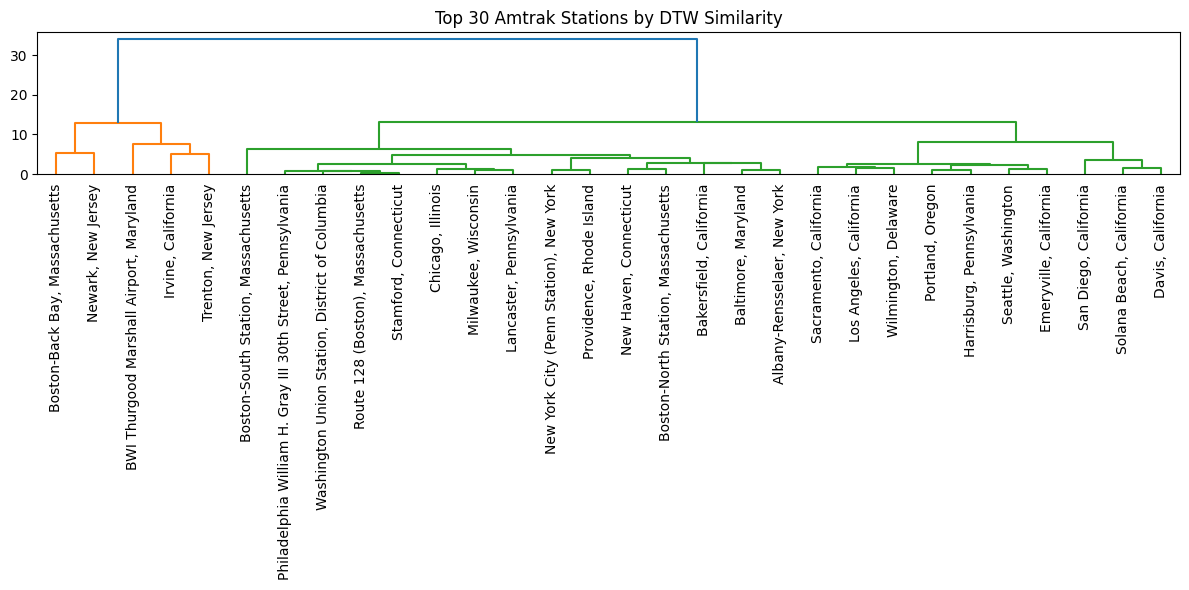

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

linked = linkage(dtw_top, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=dtw_top.index, leaf_rotation=90)
plt.title("Top 30 Amtrak Stations by DTW Similarity")
plt.tight_layout()
plt.show()

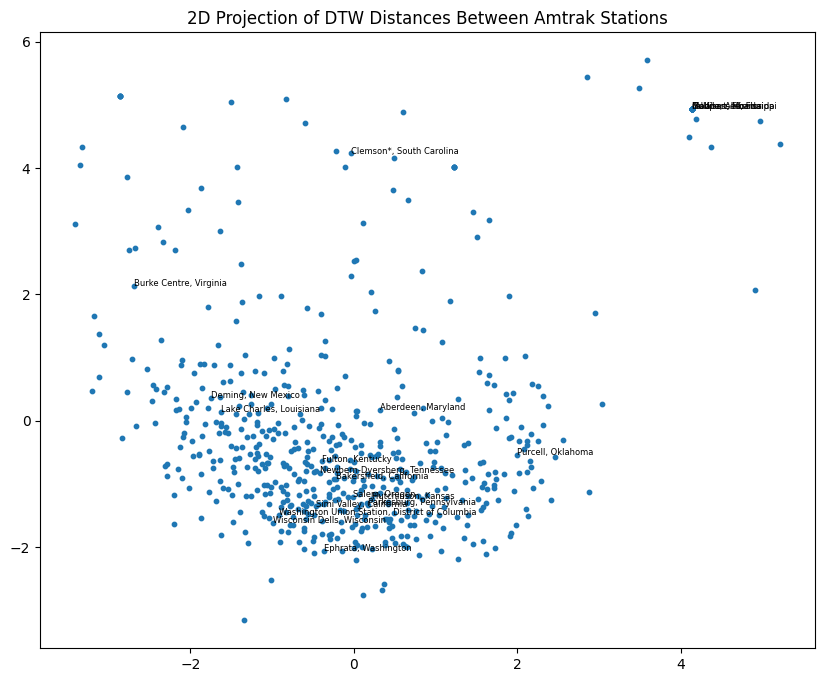

In [10]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(dtw_df)
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], s=10)
# Label a few stations to avoid clutter
for i, station in enumerate(dtw_df.index):
    if i % 30 == 0:
        plt.text(coords[i, 0], coords[i, 1], station, fontsize=6)
plt.title("2D Projection of DTW Distances Between Amtrak Stations")
plt.show()